In [1]:
from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *

### Test 1
``` a = gm([1.], [_mean], [1.]); ```


Genero sample da $\mathcal{N}(10,1)$

In [2]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim1.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

In [3]:
pars = {'mean':5.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [4]:
output_dist = start_SOGA(cfg, params_dict)

In [5]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]]])>

In [6]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((100,1))

In [7]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [8]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 5.050000190734863 loss: 1436.5272216796875
mean: 7.357654094696045 loss: 535.940673828125
mean: 8.91259479522705 loss: 230.89566040039062
mean: 9.685912132263184 loss: 171.01416015625
mean: 9.962788581848145 loss: 164.60133361816406
mean: 10.031888008117676 loss: 164.2542266845703
mean: 10.04328441619873 loss: 164.24581909179688
mean: 10.044347763061523 loss: 164.24575805664062
mean: 10.044373512268066 loss: 164.24575805664062
mean: 10.044373512268066 loss: 164.24575805664062


In [9]:
sampling_mean

tensor(10.)

In [10]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[1.]]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(164.3442)
Likelihood in the optimized distribution:  tensor(164.2458, grad_fn=<NegBackward0>)


### Test 2

``` a = gm([1.], [10.], [_std]);  ```

In [11]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim2.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

In [12]:
pars = {'std':2.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [13]:
output_dist = start_SOGA(cfg, params_dict)

In [14]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[10.]])
sigma: tensor([[[4.]]], grad_fn=<IndexBackward0>)>

In [15]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))
print('samples std', torch.std(samples))

samples std tensor(1.0036)


In [16]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


std: 1.9900000095367432 loss: 1737.8828125
std: 1.4890974760055542 loss: 1547.676025390625
std: 1.068250298500061 loss: 1426.53515625
std: 0.9991921782493591 loss: 1422.136474609375
std: 1.0032740831375122 loss: 1422.116943359375
std: 1.00320303440094 loss: 1422.1168212890625
std: 1.0031819343566895 loss: 1422.116943359375
std: 1.0031838417053223 loss: 1422.1170654296875
std: 1.0031838417053223 loss: 1422.1170654296875
std: 1.0031838417053223 loss: 1422.1170654296875


In [17]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([1.]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(1422.1270)
Likelihood in the optimized distribution:  tensor(1422.1171, grad_fn=<NegBackward0>)


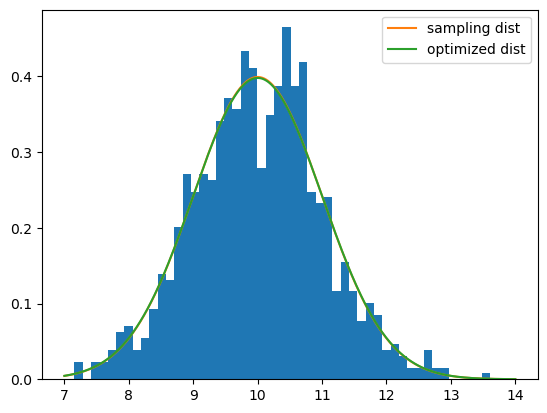

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(7,14,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), params_dict['std'].item()).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 3

```
a = gm([1.], [1.], [1.]);
a = _par1 * a + 1.;
```

sample from the program with _par1 = 2

In [24]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim3.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

In [25]:
pars = {'par1':1.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [26]:
output_dist = start_SOGA(cfg, params_dict)

In [27]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[1.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]]], grad_fn=<IndexBackward0>)>

In [28]:
sampling_mean = torch.tensor(2.)
sampling_std = torch.tensor(2.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))

In [29]:
torch.var(samples)

tensor(3.8874)

In [30]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [32]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


par1: 1.0099999904632568 loss: 3467.928466796875
par1: 1.407515525817871 loss: 2369.4072265625
par1: 1.613081693649292 loss: 2191.0
par1: 1.7398371696472168 loss: 2136.50634765625
par1: 1.825974702835083 loss: 2115.12353515625
par1: 1.886216640472412 loss: 2105.9443359375
par1: 1.9285898208618164 loss: 2101.87451171875
par1: 1.9582117795944214 loss: 2100.06640625
par1: 1.9786322116851807 loss: 2099.2763671875
par1: 1.9924358129501343 loss: 2098.9423828125


In [33]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([1.]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(2098.8230)
Likelihood in the optimized distribution:  tensor(2098.8069, grad_fn=<NegBackward0>)


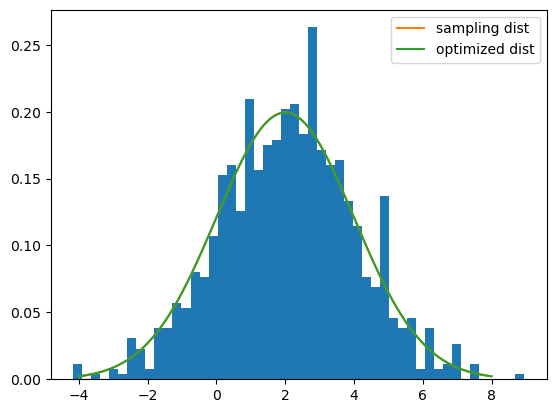

In [34]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(-4,8,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), np.sqrt(output_dist.gm.sigma[0][0,0].item())).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 4

```
a = gm([1.], [1.], [1.]);
a = 2 * a + _par2;
```

sample from the program with _par2 = 1

In [37]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim4.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

In [38]:
pars = {'par2':2.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [39]:
output_dist = start_SOGA(cfg, params_dict)

In [40]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[4.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[4.0000]]])>

In [41]:
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))

In [42]:
torch.var(samples)

tensor(4.0820)

In [44]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.001)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


par2: 1.9989999532699585 loss: 2264.742919921875
par2: 1.9493006467819214 loss: 2251.762451171875
par2: 1.9006654024124146 loss: 2239.65576171875
par2: 1.8532260656356812 loss: 2228.4169921875
par2: 1.8069932460784912 loss: 2218.00537109375
par2: 1.761977195739746 loss: 2208.382080078125
par2: 1.7181875705718994 loss: 2199.5068359375
par2: 1.6756341457366943 loss: 2191.34228515625
par2: 1.6343269348144531 loss: 2183.85009765625
par2: 1.5942758321762085 loss: 2176.9931640625


In [45]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([1.]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(2122.4250)
Likelihood in the optimized distribution:  tensor(2170.7356, grad_fn=<NegBackward0>)


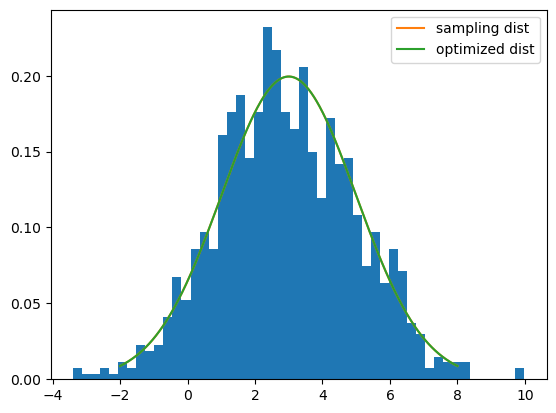

In [46]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(-2,8,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), np.sqrt(output_dist.gm.sigma[0][0,0].item())).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 5

``` 
if gm([1.], [_mean], [1.]) < 0 {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _mean = 0

In [2]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim5.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

In [3]:
cfg.node_list

{'entry': EntryNode<>,
 'test0': TestNode<test0,gm([1.],[_mean],[1.])<0>,
 'state0': StateNode<state0,True,a=gm([1.],[-5.],[1.])>,
 'state1': StateNode<state1,False,a=gm([1.],[5.],[1.])>,
 'merge0': MergeNode<merge0>,
 'exit': ExitNode<>}

In [4]:
pars = {'mean':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [5]:
output_dist = start_SOGA(cfg, params_dict)

In [6]:
output_dist

Dist<['a'],pi: tensor([[0.3085],
        [0.6915]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

In [7]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

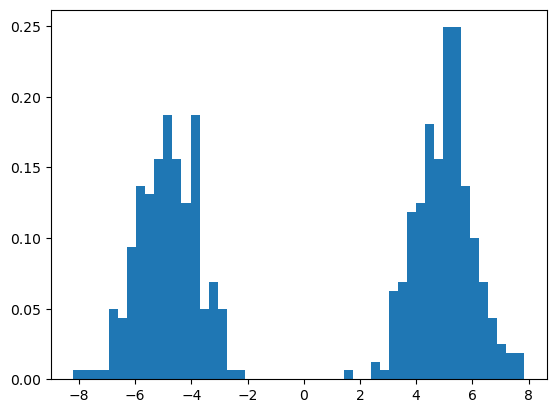

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [9]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [10]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)

    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 0.49000000953674316 loss: 1099.5511474609375
mean: 0.2172602415084839 loss: 1074.20556640625
mean: 0.07931502163410187 loss: 1070.4429931640625
mean: 0.06391045451164246 loss: 1070.4302978515625
mean: 0.07040513306856155 loss: 1070.4234619140625
mean: 0.07047038525342941 loss: 1070.42333984375
mean: 0.0701855942606926 loss: 1070.42333984375
mean: 0.07025035470724106 loss: 1070.4234619140625
mean: 0.07024329155683517 loss: 1070.42333984375
mean: 0.07024306803941727 loss: 1070.4234619140625


In [11]:
current_dist

Dist<['a'],pi: tensor([[0.4720],
        [0.5280]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

In [12]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[0.5], [0.5]]), torch.tensor([[-5.], [5.]]), torch.tensor([[[1.]], [[1.]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(1071.2078)
Likelihood in the optimized distribution:  tensor(1070.4233, grad_fn=<NegBackward0>)


In [13]:
output_dist

Dist<['a'],pi: tensor([[0.4720],
        [0.5280]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

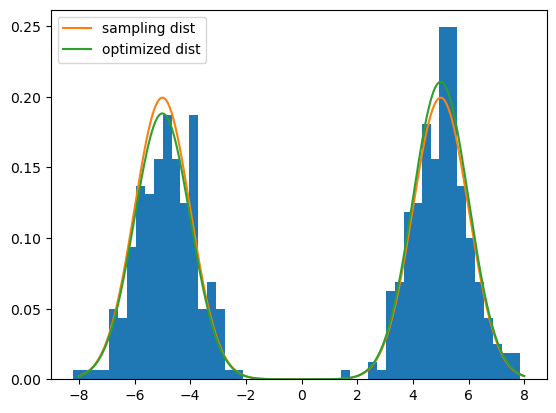

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500).view(-1,1)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 6

``` 
if gm([1.], [0.], [1.]) < _coeff {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _coeff = 0

In [16]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim6.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

In [17]:
pars = {'coeff':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [19]:
output_dist = start_SOGA(cfg, params_dict)

In [20]:
output_dist

Dist<['a'],pi: tensor([[0.6915],
        [0.3085]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

In [21]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

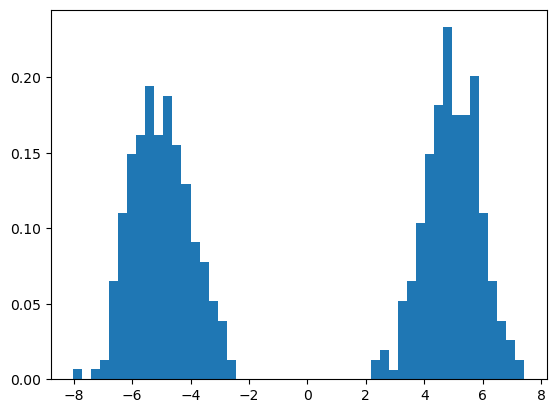

In [22]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [23]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


coeff: 0.49000000953674316 loss: 1080.541748046875
coeff: 0.21195831894874573 loss: 1048.1368408203125
coeff: 0.04263060912489891 loss: 1040.5047607421875
coeff: -0.006587794981896877 loss: 1040.090087890625
coeff: -0.007241952698677778 loss: 1040.0908203125
coeff: -0.004906479734927416 loss: 1040.08984375
coeff: -0.004929463844746351 loss: 1040.08984375
coeff: -0.005029682070016861 loss: 1040.08984375
coeff: -0.005013524554669857 loss: 1040.08984375
coeff: -0.005012519657611847 loss: 1040.08984375


In [24]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[0.5], [0.5]]), torch.tensor([[-5.], [5.]]), torch.tensor([[[1.]], [[1.]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(1040.0938)
Likelihood in the optimized distribution:  tensor(1040.0898, grad_fn=<NegBackward0>)


In [25]:
output_dist

Dist<['a'],pi: tensor([[0.4980],
        [0.5020]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

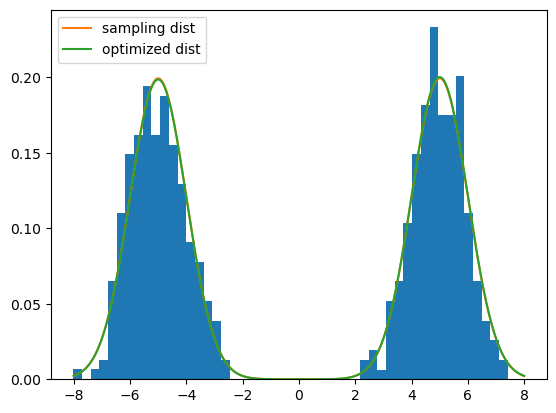

In [26]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500).view(-1,1)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 7

``` 
a = gm([1.], [_mean], [_std]); 
```

In [27]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim7.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

In [28]:
pars = {'mean':5., 'std':2.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [29]:
output_dist = start_SOGA(cfg, params_dict)

In [30]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[6.2500]]], grad_fn=<IndexBackward0>)>

In [31]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))
print('samples std', torch.std(samples))

samples std tensor(0.9495)


In [32]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(1000):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 100 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 5.010000228881836std: 2.509999990463257 loss: 3904.999755859375
mean: 5.880753517150879std: 3.2206978797912598 loss: 2952.63818359375
mean: 6.570304870605469std: 3.44724178314209 loss: 2690.399658203125
mean: 7.202902317047119std: 3.388620376586914 loss: 2520.204833984375
mean: 7.830567359924316std: 3.090935707092285 loss: 2342.21826171875
mean: 8.495575904846191std: 2.541152000427246 loss: 2098.895751953125
mean: 9.25471019744873std: 1.6798228025436401 loss: 1700.040771484375
mean: 9.962947845458984std: 0.9415715336799622 loss: 1367.4931640625
mean: 9.997222900390625std: 0.9490637183189392 loss: 1366.66796875
mean: 9.997135162353516std: 0.9490724802017212 loss: 1366.6680908203125


In [33]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[1.]]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(1369.3116)
Likelihood in the optimized distribution:  tensor(1366.6681, grad_fn=<NegBackward0>)


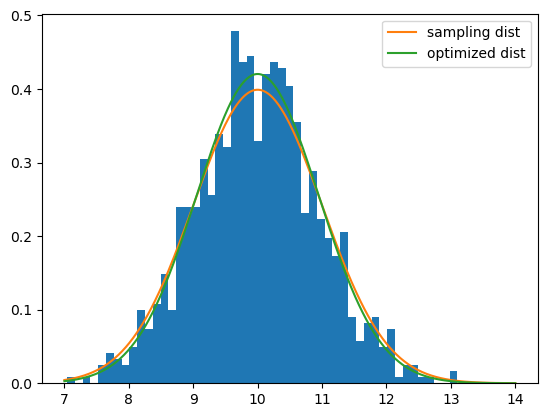

In [34]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(7,14,500).view(-1,1)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), params_dict['std'].item()).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()